# Sample Point Creation UKESM
Selects random sample of ESM3 data.

#### Dask import

<br>

#### Choices for data

In [ ]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceId = 'UKESM1-0-LL'
dataInstitutionId = 'MOHC'
approvedIds = ["r1i1p1f2", "r2i1p1f2", "r3i1p1f2"] #insert start of approved member_ids

#Custom Variables
levSel = slice(0, 2000) #Selected levels to be investigated
maxLat = -30 #Selected latitude to be investigated
maskName = "OceanMaskVolcello"
lastESMDecade = slice('2005-01','2014-12')

exportName = "GMMSampleMeta"

<br>

#### Importing Libaries

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.dataframe as dd
import fsspec
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import xarray as xr
import zarr

from dask import config
from dask import delayed
from matplotlib.pyplot import cm

config.set(**{'array.slicing.split_large_chunks': True})
print("Imports complete")

Imports complete


<br>

#### Loading Data

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
dfFilt = df[df.variable_id.eq(dataVariableId) & df.experiment_id.eq(dataExperimentId) & df.source_id.eq(dataSourceId) & df.institution_id.eq(dataInstitutionId)]

memberArr = np.empty(shape=(0), dtype=bool)
for i in dfFilt["member_id"]:
    rowSel = i[:] in approvedIds #adapt i[:] to match size of approvedIds
    memberArr = np.append(memberArr, rowSel)

memberSer = pd.Series(memberArr, name='bools')
dfFilt = dfFilt[memberSer.values]
dfFilt = dfFilt[:1]

fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)
if fileCount:
    print(str(fileCount)+" "+dataSourceId+" data sets opened")
else:
    print("No UKESM data sets opened")
    
for i in range(fileCount): #Formatting dates into np.datetime64 format
    startDateIterate = np.datetime64(fileSetList[i]['time'].values[0],'M')
    endDateIterate = np.datetime64(fileSetList[i]['time'].values[-1],'M') + np.timedelta64(1,'M')
    fileSetList[i]['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 
fileSet = xr.combine_nested(fileSetList, concat_dim='RunId') #Combining data sets
print("Data sets successfully merged")

dfESMLat = fileSet.thetao.where(fileSet.latitude < maxLat, drop=True) #Selection of latitude
dfESMLatLev = dfESMLat.sel(lev=levSel) #Selects level data down to 2k
dfESMLatLevT = dfESMLatLev.sel(time=lastESMDecade)
#dfESMLatLevT = dfESMLatLevT.reset_coords(drop=True) #Removes lev if single value

globalStartDate = dfESMLatLevT["time"][0].values
globalDateInc = dfESMLatLevT["time"][1].values - globalStartDate
#np.datetime64(globalDateInc,'D')
globalEndDateIn = dfESMLatLevT["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("UKESM data loaded and stored in dfESMLatLevT")
#dfESMLatLevT #Uncomment to see data set

1 UKESM1-0-LL data sets opened
Data sets successfully merged
UKESM data loaded and stored in dfESMLatLevT


In [4]:
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
print("Mask data loaded into oceanMask.")

Mask data loaded into oceanMask.


<br>

#### Calculation Functions
<b>Functions:</b><br>
<ul>
<li>pickRand - Takes in data frame and returns sampled data frame with a randomly selected number of rows from the input data frame, controled by the second input variable to the function.
<li>storeMeta - Returns a np array containing the latitude and longitude data for an input xarray and associated ij.
</ul>

In [5]:
def pickRand(dataArray, sampleFactor):
    '''Returns a sample of the input array, size of sampled array is based on sampleFactor. For factor > 1 that many points are chosen, for factor < 1 that % is taken of the array'''
    arrLen = len(dataArray)
    if sampleFactor > 1:
        sampleSize = int(sampleFactor)
    elif sampleFactor > 0:
        sampleSize = int(sampleFactor*arrLen)
    else:
        return 1
    
    filtArr = np.zeros(arrLen, dtype=bool) # empty mask
    sampleId = np.random.choice(arrLen, sampleSize, False) # np array of randomly generated non repeating numbers
    for i in sampleId:
        filtArr[i] = True # populating mask
    return dataArray[filtArr] # applies mask

def storeMeta(dataArray):
    '''Returns a np array containing the latitude and longitude data for the input xarray and the associated ij index'''
    storeLen = len(dataArray["lat"]) # assumes each lat has a corresponding lon
    storage = np.empty(shape=(0,storeLen))
    storage = np.append(storage, [dataArray["lat"].values], axis = 0)
    storage = np.append(storage, [dataArray["lon"].values], axis = 0)
    storage = np.append(storage, [dataArray["ij"].values], axis = 0)
    return storage

print("Calculation functions defined.")

Calculation functions defined.


<br>
<b>Placing valid locations into an array</b><br>
Ocean mask here is used as it was generated from UKESM data, however it would be more accurate to use the ESM sample data straight.

In [6]:
geoRange = oceanMask #copying mask
geoRange = geoRange.stack(ij =("i", "j")) #Stacking
geoRange = geoRange.rename({"variable":"cleanMe"}) #Dimension removal
geoRange = geoRange.sel(cleanMe = geoRange.cleanMe.values[0]) #Dimension removal
geoRange = geoRange.reset_coords("cleanMe", drop=True) #Dimension removal
geoRangeFilt = geoRange.dropna("ij")
print("Ocean mask unpacked into geoRangeFilt.")

Ocean mask unpacked into geoRangeFilt.


<br>

#### Plotting Functions
<b>Functions:</b><br>
<ul>
<li>locationPlotSimple - Plots locations of an input data array on a map.
<li>locationPlot - Plots locations of an input data array on a map with a colour scale for time.
<li>latDistribution - Plots latitude distribution of an input data array as a histogram.
<li>latDistributionCompare - Plots latitude distribution of two input data arrays against each other as histograms.
<li>lonDistribution - Plots longitude distribution of an input data array as a histogram.
<li>lonDistributionCompare - Plots longitude distribution of two input data arrays against each other as histograms.
<li>timeDistribution - Plots time distribution of an input data array as a histograt
</ul>

In [7]:
def locationPlotSimple(dataArray, size, plotNo):
    '''Plots locations of numpy arrays'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    plt.scatter(dataArray[1], dataArray[0], transform=ccrs.PlateCarree(), color = "Red")
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray[0]))+")")
    
def locationPlotSimpleRec(dataArray, size, plotNo):
    '''Plots locations of numpy arrays'''
    plt.figure(plotNo, figsize=size)
    plt.scatter(dataArray[1], dataArray[0], color = "Red")
    plt.title("Sample Locations ("+str(len(dataArray[0]))+")")
    
    
def locationPlot(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray[1], dataArray[0], transform=ccrs.PlateCarree(), c= mdates.date2num(dataArray[2]), cmap='brg')
    cb = plt.colorbar(im)
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray[0]))+")")
    
def locationPlotXr(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray["lon"], dataArray["lat"], transform=ccrs.PlateCarree())
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray["lat"]))+")")    
    
def latDistribution(dataArray, binSize, plotNo):
    '''Plots latitude distribution of input data array'''
    if not binSize: binSize = 2
    plt.figure(plotNo)
    latDistri = np.arange(-89.5, -29.4, binSize)
    plt.hist(dataArray["lat"], bins = latDistri)
    plt.title("Latitude distribution of data points (Bin size:"+str(binSize)+")")
    
def latDistributionCompare(dataArrayS, dataArrayO, binSize, plotNo):
    '''Plots and compares latitude distribution of input data arrays'''
    if not binSize: binSize = 2
    plt.figure(plotNo, figsize=(10,7))
    latDistri = np.arange(-89.5, -29.4, binSize)
    latWeightsS = np.ones_like(dataArrayS["lat"])/float(len(dataArrayS["lat"]))
    latWeightsO = np.ones_like(dataArrayO["lat"])/float(len(dataArrayO["lat"]))
    plt.hist(dataArrayS["lat"], bins = latDistri, weights = latWeightsS, alpha=0.5, label="Sampled data")
    plt.hist(dataArrayO["lat"], bins = latDistri, weights = latWeightsO, alpha=0.5, label="Original data")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Latitude distribution of data points compared to original data set distribution (Bin size:"+str(binSize)+")")
    
def lonDistribution(dataArray, binSize, plotNo):
    '''Plots longitude distribution of input data array'''
    if not binSize: binSize = 3
    plt.figure(plotNo)
    lonDistri = np.arange(-180, 180.1, binSize)
    plt.hist(dataArray["lon"], bins = lonDistri)
    plt.title("Longitude distribution of data points (Bin size:"+str(binSize)+")")
    
def lonDistributionCompare(dataArrayS, dataArrayO, binSize, plotNo):
    '''Plots and compares longitude distribution of input data arrays'''
    if not binSize: binSize = 3
    plt.figure(plotNo, figsize=(10,7))
    lonDistri = np.arange(-180, 180.1, binSize)
    lonWeightsS = np.ones_like(dataArrayS["lon"])/float(len(dataArrayS["lon"]))
    lonWeightsO = np.ones_like(dataArrayO["lon"])/float(len(dataArrayO["lon"]))
    plt.hist(dataArrayS["lon"], bins = lonDistri, weights = lonWeightsS, alpha=0.5, label="Sampled data")
    plt.hist(dataArrayO["lon"], bins = lonDistri, weights = lonWeightsO, alpha=0.5, label="Original data")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Longitude distribution of data points compared to original data set distribution (Bin size:"+str(binSize)+")")
    
def timeDistribution(dataArray, plotNo):
    plt.figure(plotNo)
    timeDistri = np.arange(np.datetime64("2005-01", "M"), np.datetime64("2015-02", "M")) #last date is excluded (max "2015-01"), 2014-12 needs monthly bin
    plt.hist(dataArray[2], bins = timeDistri)
    plt.title("Time distribution of data points")
    
    
print("Plotting functions defined")

Plotting functions defined


<br>

#### Testing GeoRange storage

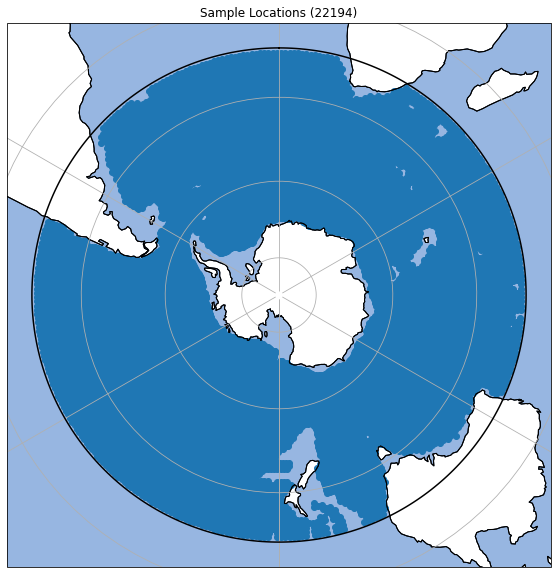

In [8]:
locationPlotXr(geoRangeFilt, (20, 10), 1)

#### Displaying of data
<b>Demonstration of random sampling - 10 small scale samples</b>

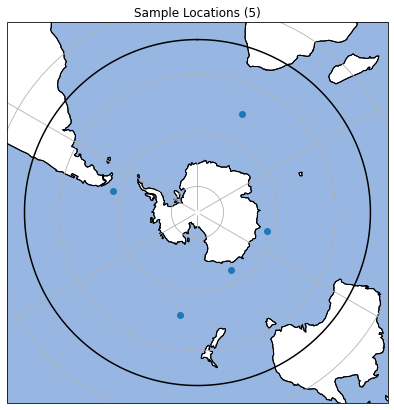

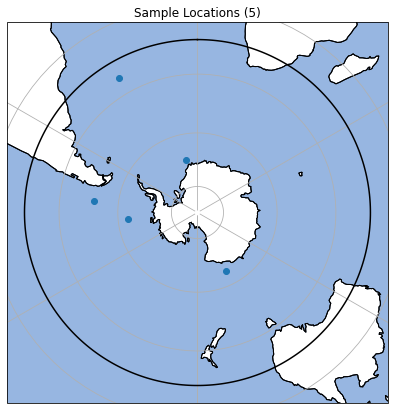

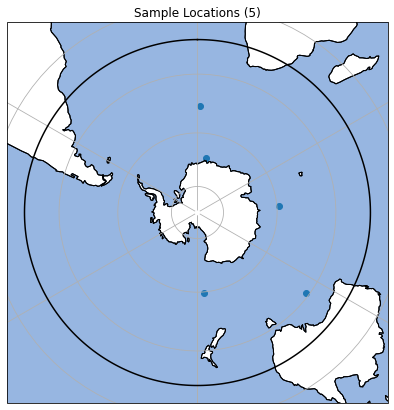

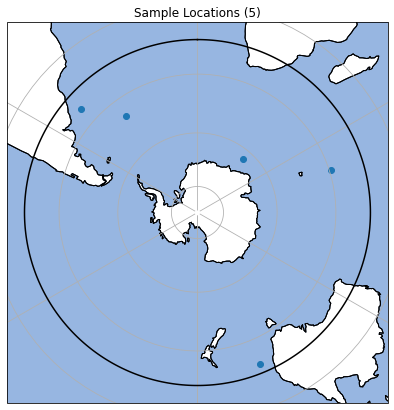

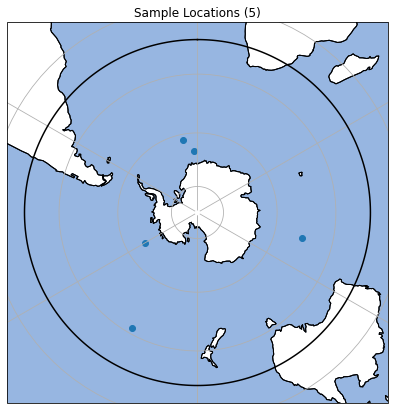

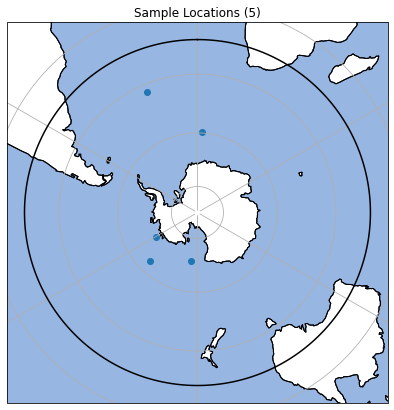

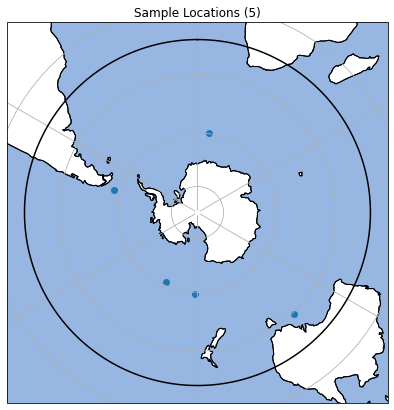

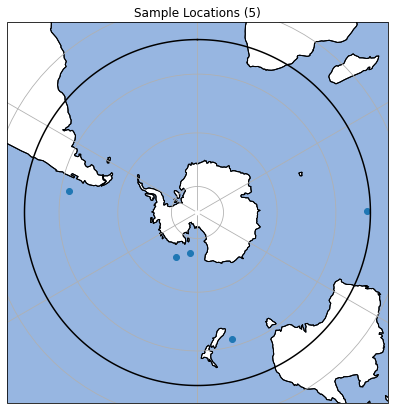

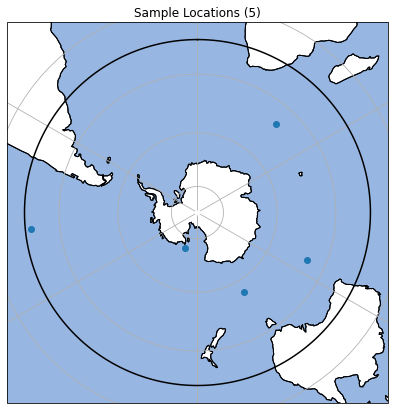

In [9]:
sampleSize = 5
sampleList = np.empty(shape=(0, 3, sampleSize))
for i in range(1, 10):
    samples = pickRand(geoRangeFilt, sampleSize)
    samplesMeta = storeMeta(samples)
    sampleList = np.append(sampleList, [samplesMeta], axis=0)
    locationPlotXr(samples, (7,7), i) 

<br>
<b>Demonstration of saving meta data for replication</b>

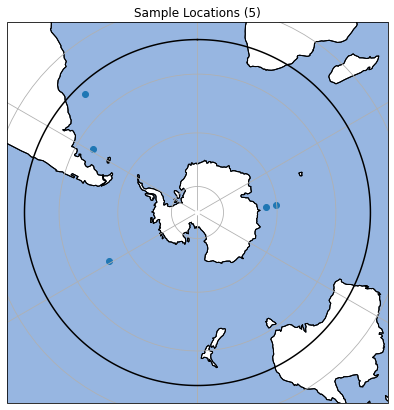

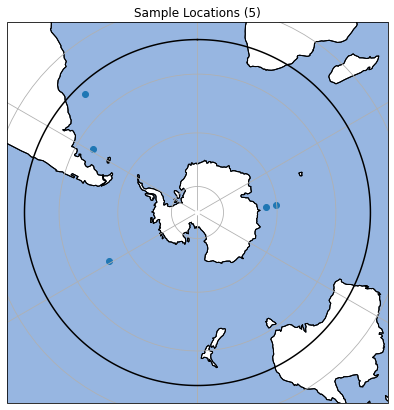

In [10]:
temp = pickRand(geoRangeFilt, 5)
locationPlotXr(temp, (7,7), 1)
tempMeta = storeMeta(temp)
temp2 = geoRangeFilt.sel(ij = tempMeta[2])
locationPlotXr(temp2, (7,7), 2)
plt.show()

<br>
<b>Large Random Sample</b>

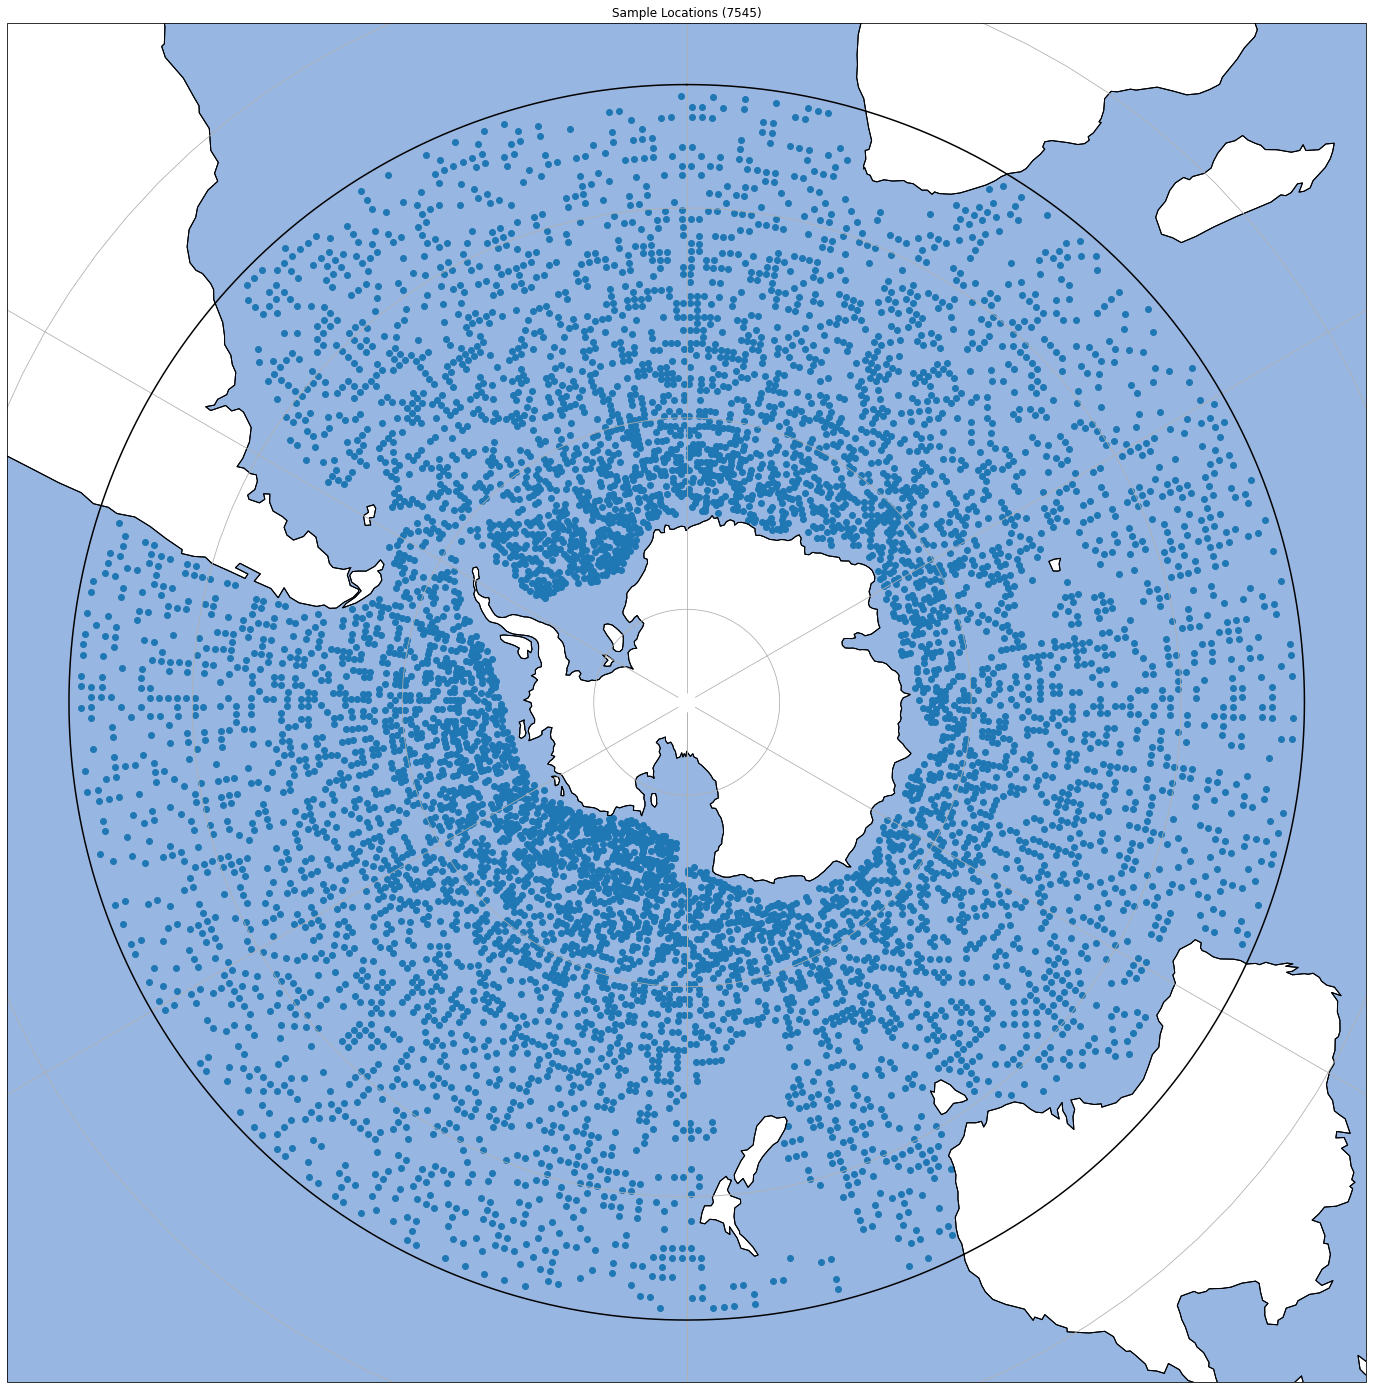

In [11]:
sampleDataPoints = pickRand(geoRangeFilt, 0.34)
samplesDataPointsMeta = storeMeta(samples)
locationPlotXr(sampleDataPoints, (25,25), 1)

<br>
<b>Latitude and Longitude distribution of large sample</b>

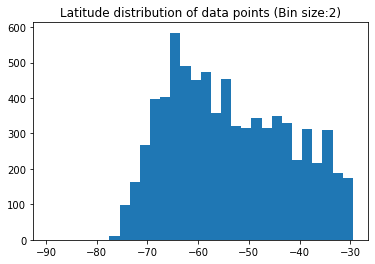

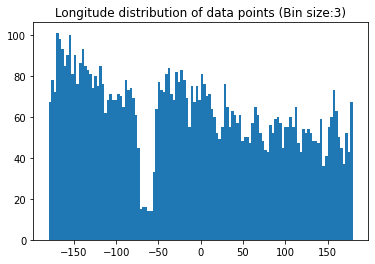

In [12]:
latDistribution(sampleDataPoints, 2, 1)
lonDistribution(sampleDataPoints, 3, 2)

<br>
<b>Latitude and Longitude distribution of large sample, compared to distributions of original data set</b>

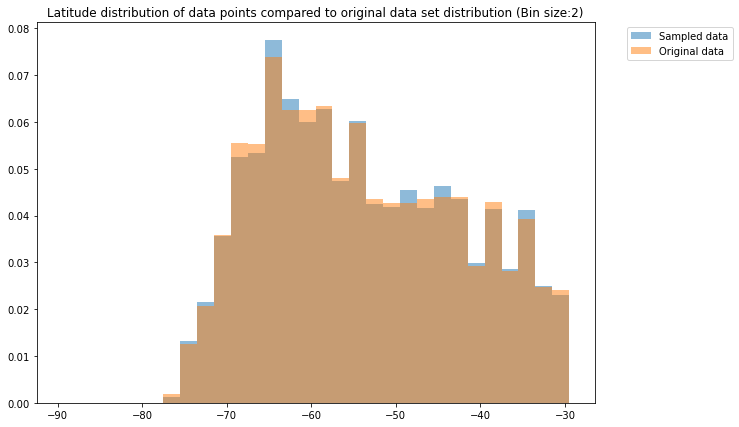

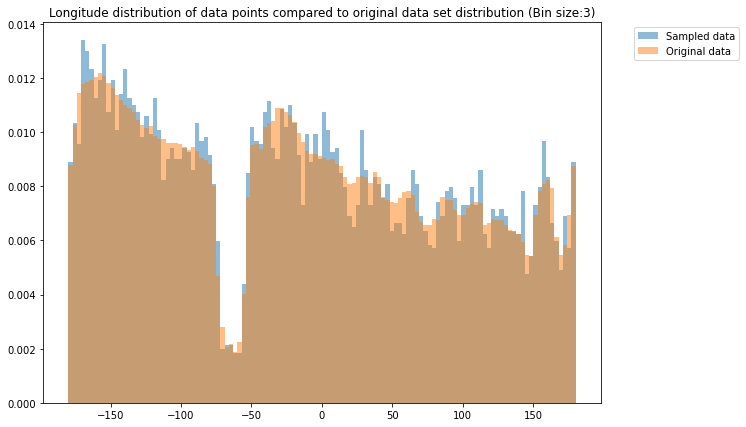

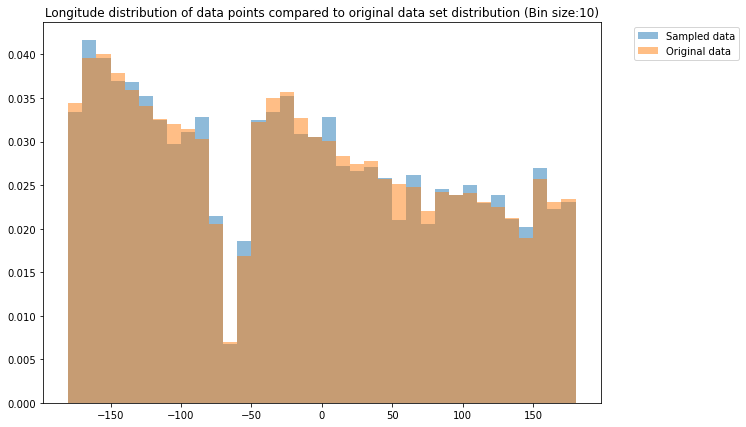

In [13]:
latDistributionCompare(sampleDataPoints, geoRangeFilt, 2, 1)
lonDistributionCompare(sampleDataPoints, geoRangeFilt, 3, 2)
lonDistributionCompare(sampleDataPoints, geoRangeFilt, 10, 3)

<br>
<b>Exporting Chosen Sample Time/Location Data</b>

In [14]:
sampleDataPointsSimple = sampleDataPoints.reset_index('ij')
sampleDataPointsSimple.to_netcdf(exportName)
print("Data saved and exported to "+exportName)

Data saved and exported to GMMSampleMeta


<br>
<b>Reloading of Sample Time/Location Data file</b>

Reloaded data first, with original data below


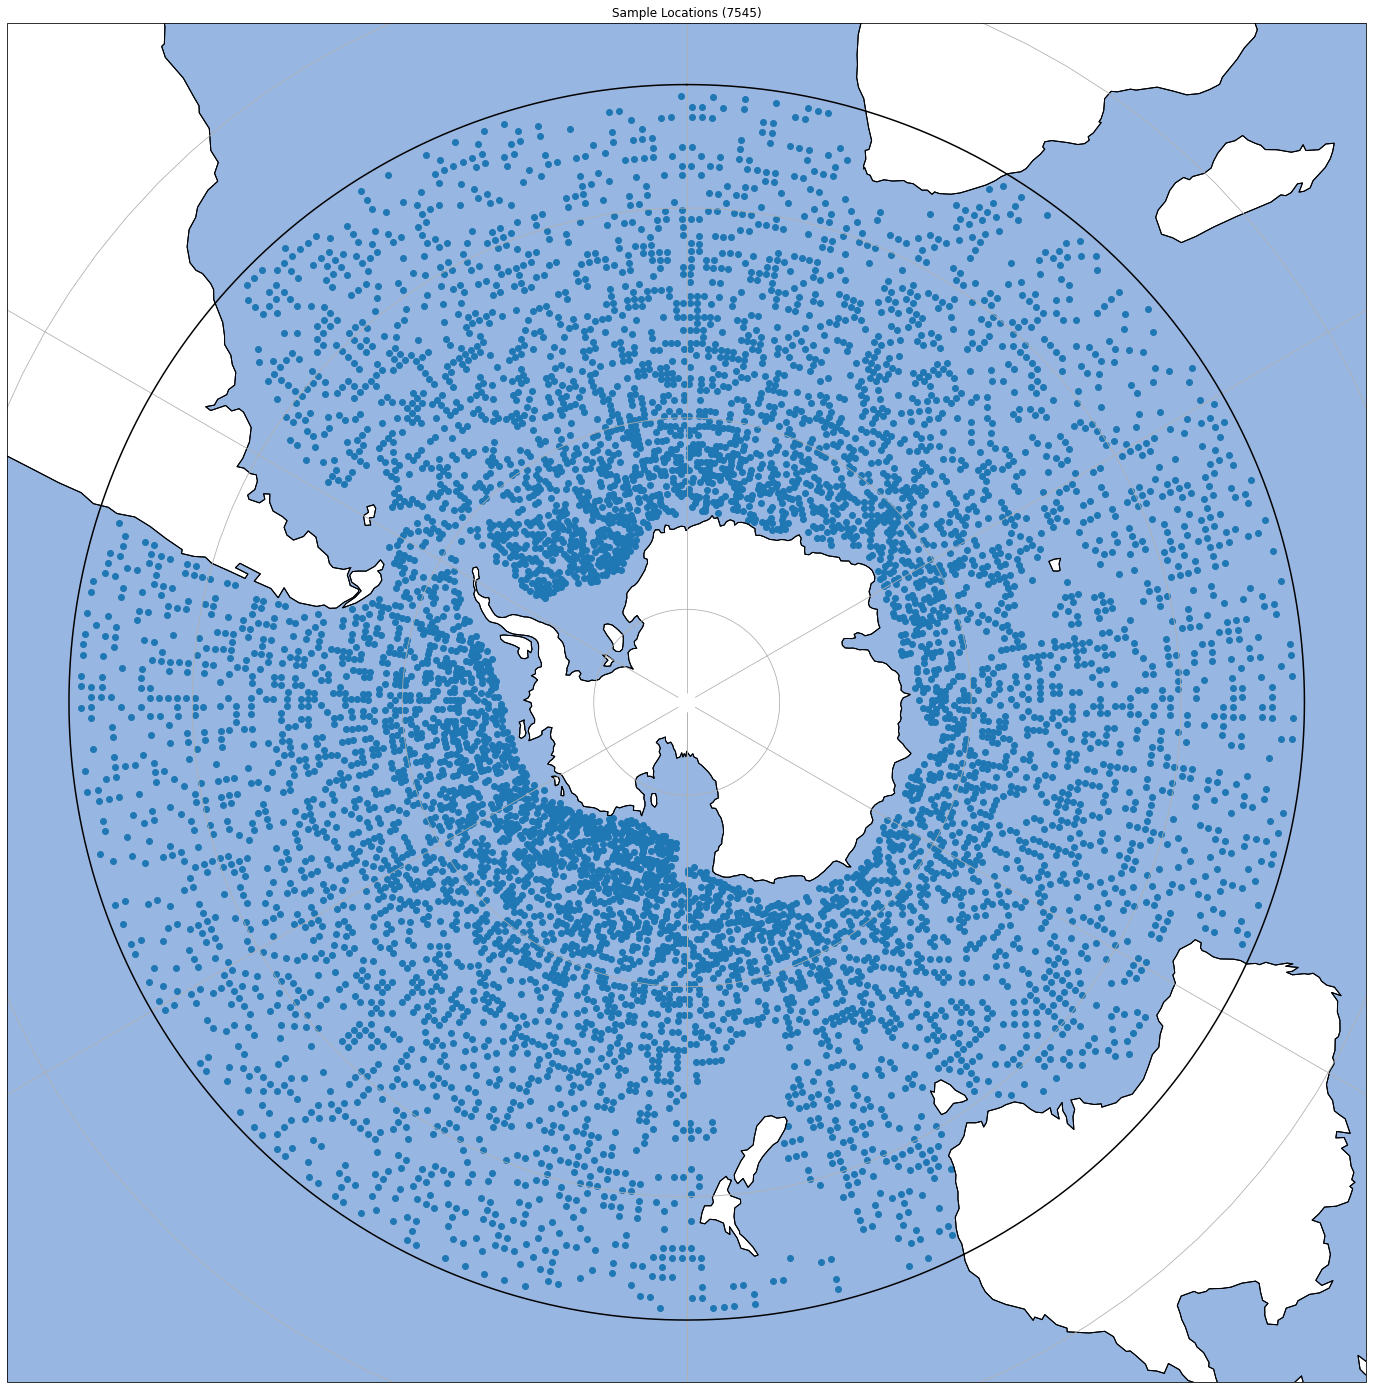

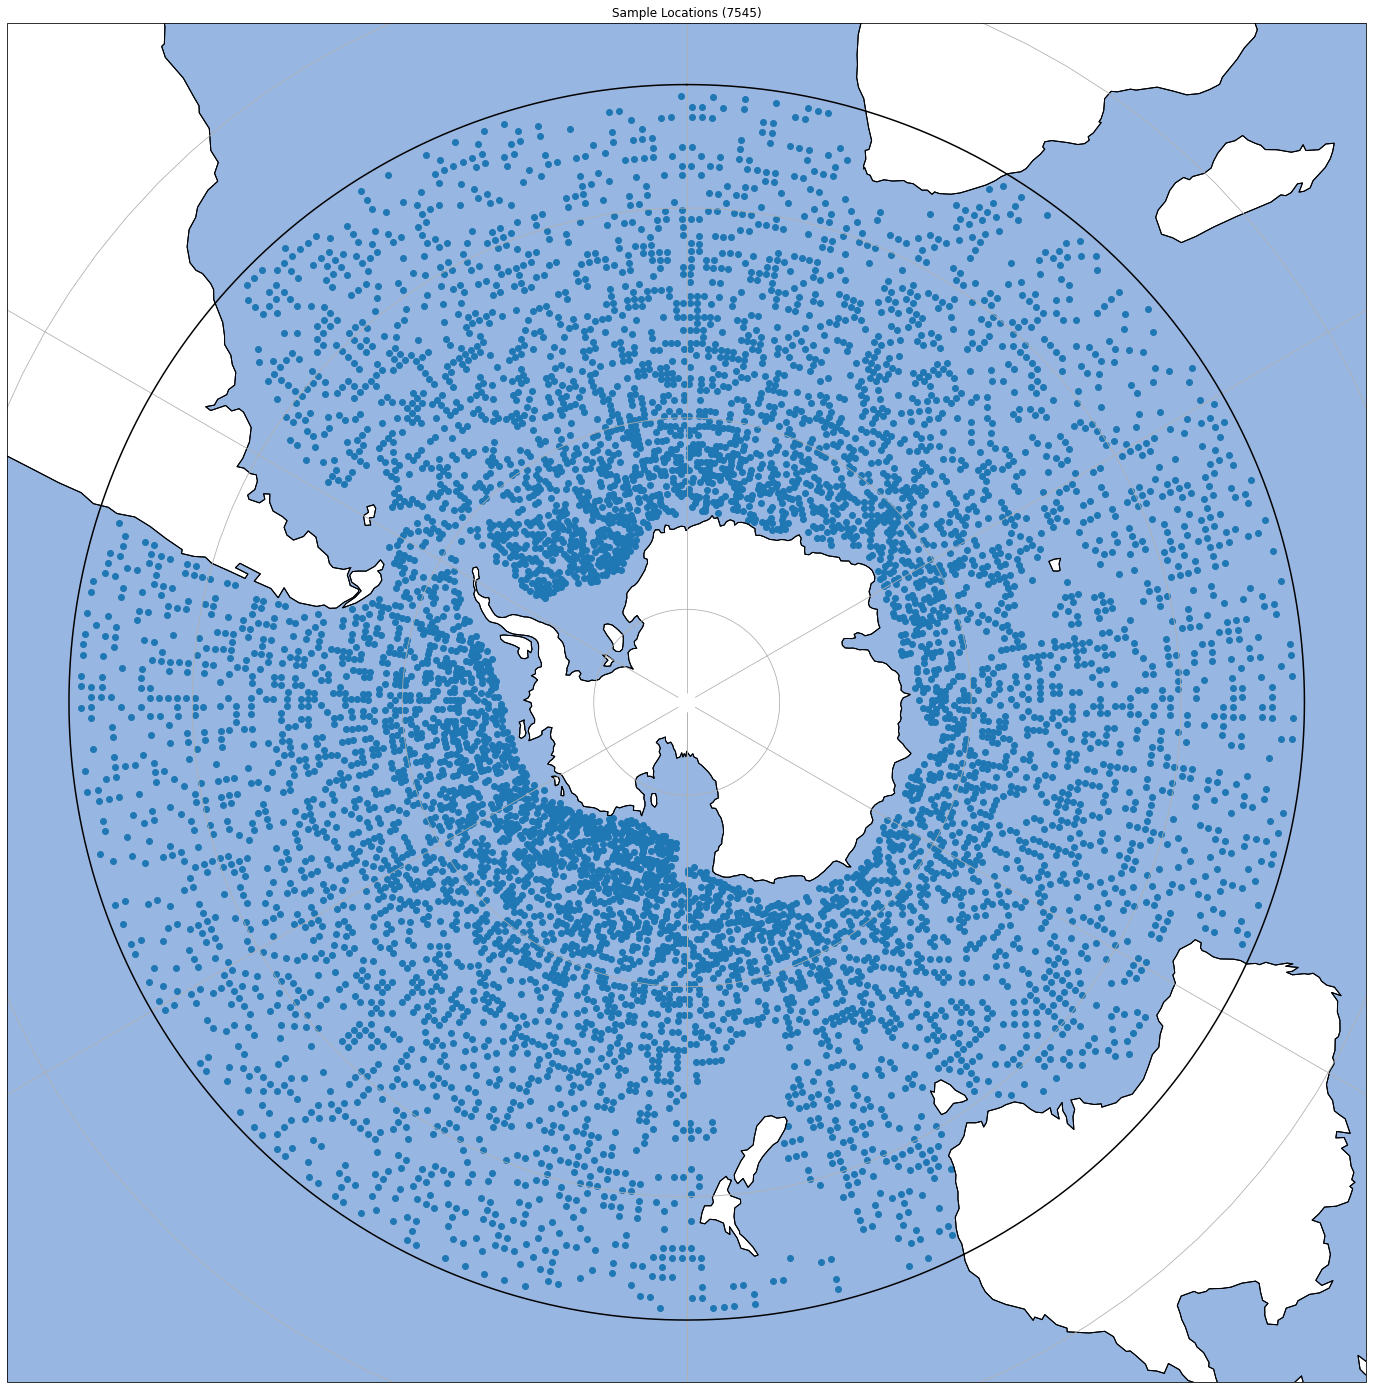

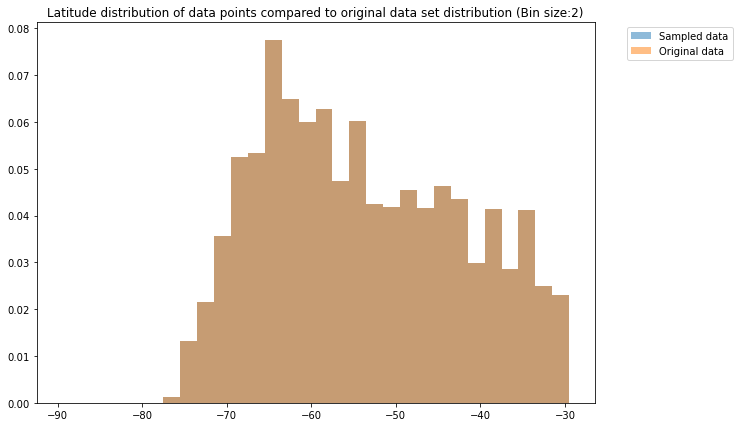

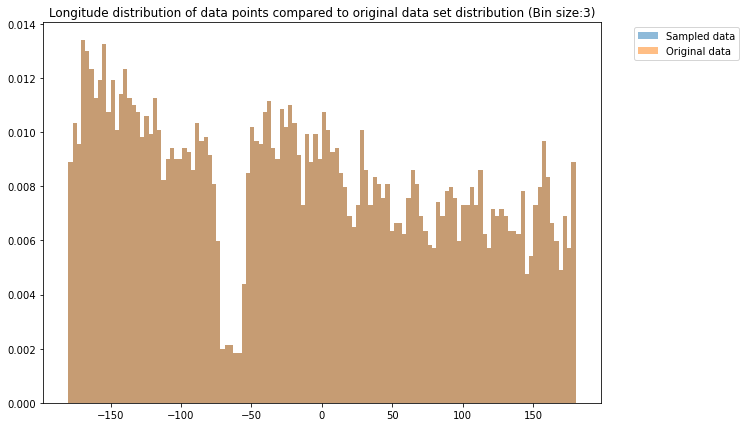

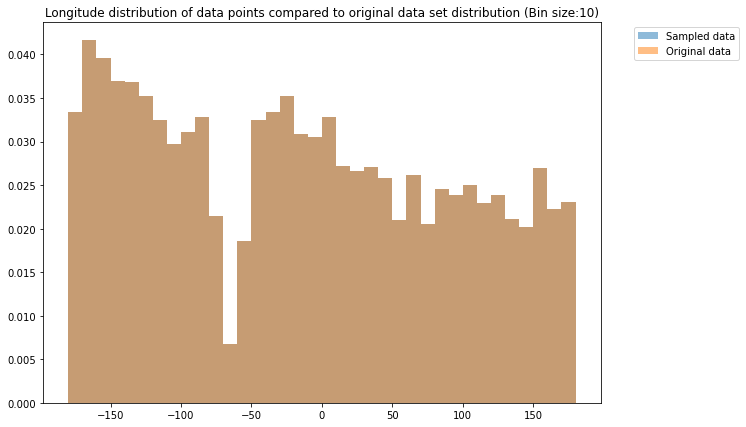

In [15]:
reloadSampleDataPoints = xr.open_dataset(exportName)
locationPlotXr(reloadSampleDataPoints, (25,25), 1)
print("Reloaded data first, with original data below")
locationPlotXr(sampleDataPoints, (25,25), 2)
latDistributionCompare(reloadSampleDataPoints, sampleDataPoints, 2, 3)
lonDistributionCompare(reloadSampleDataPoints, sampleDataPoints, 3, 4)
lonDistributionCompare(reloadSampleDataPoints, sampleDataPoints, 10, 5)